In [3]:
# %pip install tensorflow[and-cuda]
%pip install --upgrade setuptools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten

In [29]:
%cd /home/elias/Coding/training/Studium/KI/HAW-KI-Praktika

/home/elias/Coding/training/Studium/KI/HAW-KI-Praktika


/home/elias/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [51]:
import json
from os import listdir
from os.path import isfile, join
import numpy as np

training_path = "./training_data/2025-01-09/"

onlyfiles = [f for f in listdir(training_path) if isfile(join(training_path, f))]

matrices = []

for file in onlyfiles:
    with open(training_path+file) as f:
        d = json.load(f)

        # print("move:" + str(d["move"]))
        # print("score:" + str(d["score"]))

    matrices.append(d["move"])

matrices = np.array(matrices)


In [54]:
matrice_len = len(matrices[0])
matrice_height = len(matrices[0][0])

print(matrice_len)
print(matrice_height)

5
4


In [57]:
# prompt: generate a custom dataset with random 8x8 matrixes that have the numbers 0-4 on each field. rate each field higher the more high the sum of all fields is.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten
import numpy as np
import random

num_samples = len(matrices)  # Number of samples in the dataset
number_generated_boards = 0

# # Generate random 8x8 matrices with values 0-4 (leave rows 3 to 6 blank)
# def generate_checkerboard():
#     board = [[random.randint(0, 4) for _ in range(8)] for _ in range(8)]

#     # Ensure there's at least one piece of each type (0-3)
#     pieces = [0, 1, 2, 3]
#     for row in range(0, 8):
#         for col in range(8):
#           if len(pieces) == 0:
#               pieces = [0, 1, 2, 3]
#           piece = random.choice(pieces)
#           board[row][col] = piece
#           pieces.remove(piece)

#     global number_generated_boards
#     number_generated_boards += 1

#     # if number_generated_boards % 1000 == 0:
#         # print(f"Generated {number_generated_boards} boards")

#     return board

# matrices = np.array([generate_checkerboard() for _ in range(num_samples)])

# Calculate the real value of each matrix
# the more numbers at top is the higher the value
# so p[0,0] evaluates to matrice_len
# p[0,7] to 0
# p[2,7] to 0
# p[5,6] to 1
# if a 0 is at any position it evaluets to 0
def calculate_real_value(matrix):
    rows, cols = len(matrix), len(matrix[0])
    result = 0

    for i in range(rows):
        for j in range(cols):
            result += matrix[i][j] * (matrice_len - (i + j))

    return result

matrix_values = np.zeros(num_samples)
for i in range(num_samples):
    matrix_values[i] = np.sum(calculate_real_value(matrices[i]))


# Normalize
normalized_sums = (matrix_values - np.min(matrix_values)) / (np.max(matrix_values) - np.min(matrix_values))

# Create labels based on normalized sums (higher sum = higher rating)
labels = normalized_sums.reshape(-1, 1)
non_normalized_labels = matrix_values.reshape(-1, 1)

# Reshape matrices to be compatible with neural network input (samples, 8, 8, 1)
reshaped_matrices = matrices.reshape(-1, matrice_len, matrice_height, 1)

# Convert to tensors
matrices_tensor = tf.convert_to_tensor(reshaped_matrices, dtype=tf.float32)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

print("Shape of matrices:", matrices_tensor.shape)
print("Shape of labels:", labels_tensor.shape)

# Example usage of the dataset (assuming you have a model defined)
# model.fit(matrices_tensor, labels_tensor, epochs=10)

Shape of matrices: (9798, 5, 4, 1)
Shape of labels: (9798, 1)


In [7]:
%pip install numpy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 7.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 7.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 7.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


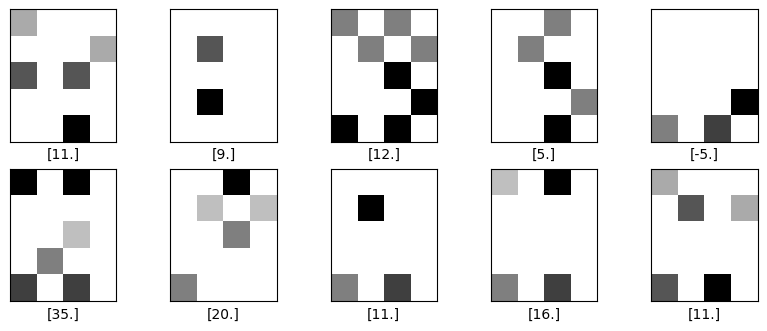

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# plot 10 with labels
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(matrices[i], cmap=plt.cm.binary)
    plt.xlabel(non_normalized_labels[i])
plt.show()


In [60]:
model= Sequential()
model.add(Flatten(input_shape=(matrice_len, matrice_height)))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

/home/elias/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,169 (59.25 KB)

 Trainable params: 15,169 (59.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 7.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 7.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [61]:
# split sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(matrices, labels, test_size=0.2, random_state=42)

In [62]:
from tensorflow.keras.callbacks import EarlyStopping
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
                    epochs=25,
                    batch_size=32,  # Add batch size
                    validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0075 - mae: 0.0564 - val_loss: 0.0010 - val_mae: 0.0239
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6791e-04 - mae: 0.0158 - val_loss: 2.6323e-04 - val_mae: 0.0116
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8460e-04 - mae: 0.0098 - val_loss: 1.6326e-04 - val_mae: 0.0088
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2532e-04 - mae: 0.0080 - val_loss: 1.4048e-04 - val_mae: 0.0085
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.9779e-05 - mae: 0.0068 - val_loss: 8.6153e-05 - val_mae: 0.0059
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2257e-05 - mae: 0.0055 - val_loss: 7.1176e-05 - val_mae: 0.0056
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.9222e-05 - mae: 0.0054 - val_loss: 6.3465e-05 - val_mae: 0.0051
Epoch 8/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0378e-05 - mae: 0.0049 - val_loss: 5.9502e-05 - val_mae: 0.0050

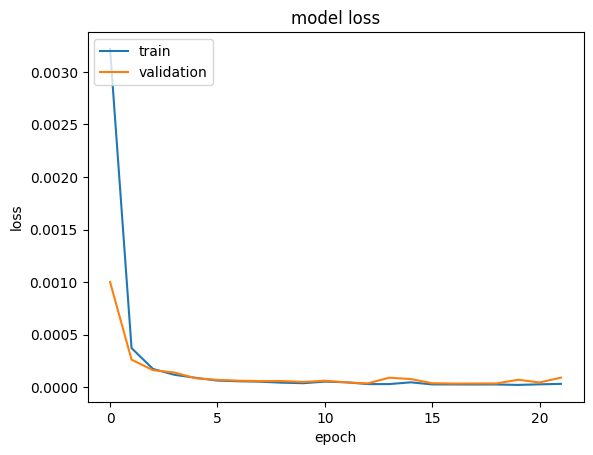

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

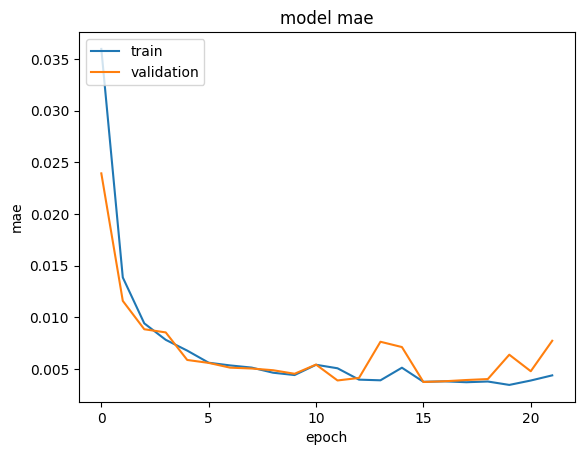

In [64]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [65]:
y_test.shape

(1960, 1)

In [66]:
import matplotlib.pyplot as plt

predictions = model.predict(X_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [67]:
from sklearn.metrics import accuracy_score
# convert floats to integer (*10)
predictions_acc = (predictions * 10).astype(int)
y_test_acc = (y_test * 10).astype(int)
accuracy = accuracy_score(y_test_acc, predictions_acc)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.33%


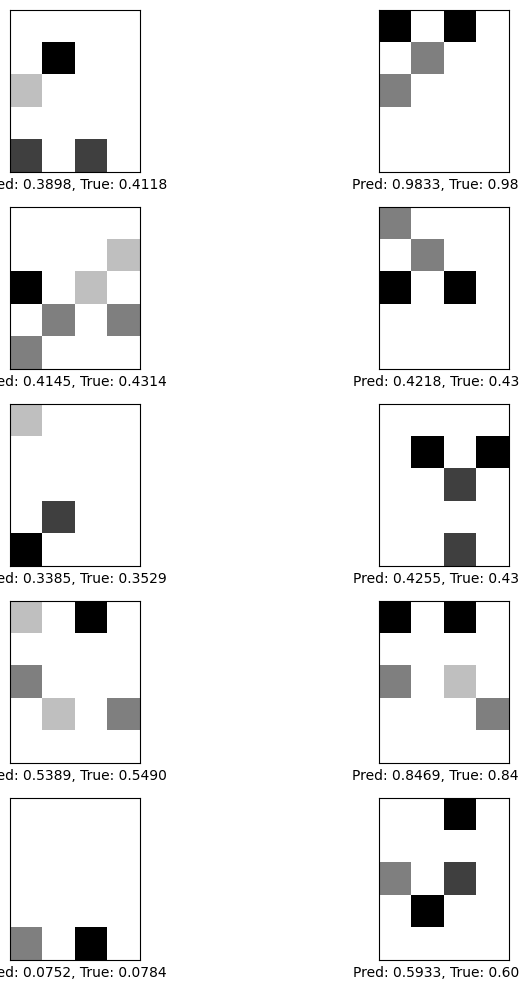

In [70]:
# Plot predictions with true values
plt.figure(figsize=(10, 10))
for i in range(10,20):
    plt.subplot(5, 2, i%10 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i].reshape(matrice_len, matrice_height), cmap=plt.cm.binary)  # Reshape for imshow
    plt.xlabel(f"Pred: {predictions[i][0]:.4f}, True: {y_test[i][0]:.4f}")
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()